In [ ]:
import searchnets.data
import searchnets.test

from configparser import ConfigParser
configfile = '~/Documents/repos/L2M/visual-search-nets/data/configs/searchnets_feature_search_alexnet.ini'

config = ConfigParser()
config.read(configfile)

## Make new 'feature' visual search stimuli datasets with differing discriminability of target and distractors
'Feature' search is red vertical rectangle target v. green vertical rectangle distractors.
Here the red and green are both moved closer to yellow, e.g. for the value of 51 the "red" target's RGB color is `[255 51 0]` while the "green" distractor is `[51 255 0]`. Since `[255 255 0]` is yellow, both the target and distractor colors are being shifted closer to yellow, but from opposite directions.

In [ ]:
for num in [51, 102, 153, 204]:
    config['DATA']['TRAIN_DIR'] = f'../../data/experiment_1/visual_search_stimuli/searchstims_feature_{num}_alexnet'
    config['DATA']['GZ_FILENAME'] = f'../../data/experiment_1/data_prepd_for_nets/feature_search_{num}_alexnet_data.gz'
    config['DATA']['TRAIN_SIZE'] = '400'
    config['DATA']['VALIDATION_SIZE'] = '200'
    searchnets.data.data(config)

## Use new datasets with different target-distractor discriminabilities to get accuracy of neural networks previously trained on this 'feature' visual search task

In [ ]:
for num in [51, 102, 153, 204]:
    config['DATA']['TRAIN_DIR'] = f'../../data/visual_search_stimuli/searchstims_feature_{num}_alexnet'
    config['DATA']['GZ_FILENAME'] = f'../../data/data_prepd_for_nets/feature_search_{num}_alexnet_data.gz'
    config['DATA']['TRAIN_SIZE'] = '400'
    config['DATA']['VALIDATION_SIZE'] = '200'
    config['TRAIN']['MODEL_SAVE_PATH'] = '../../data/checkpoints/feature_search_alexnet_models/'
    config['TEST']['TEST_RESULTS_SAVE_PATH'] = f'../../data/results/feature_search_{num}_alexnet_models/'
    searchnets.test.test(config)

## Munge test accuracy data

In [1]:
import joblib
acc_by_epoch = {}

epoch_list = [10, 50, 200, 400, 800]
for epochs in epoch_list:
    acc_by_diff = {}
    for num in [0, 51, 102, 153, 204]:       
        if num == 0:
            test_results_save_path = f'../../data/results/feature_search_alexnet_models/test_alexnet_trained_{epochs}_epochs.gz'
        else:    
            test_results_save_path = f'../../data/results/feature_search_{num}_alexnet_models/test_alexnet_trained_{epochs}_epochs.gz'

        test_results = joblib.load(test_results_save_path)
        acc_by_diff[num]= test_results['acc_per_set_size_per_model']
    acc_by_epoch[epochs] = acc_by_diff

set_sizes = [1,2,4,8]
discrim_nums = [204, 153, 102, 51, 0]  # from least to most discriminable
subjects_by_epochs = {}
num_subjects = 5  # each trained neural net is a 'subject' in our psychophys experiment; what we called a "replicate" when repeating training before

for epochs in epoch_list:
    subjects = {}
    for subject_ind in range(num_subjects):
        acc_by_discrim_by_set_size = {set_size:[] for set_size in set_sizes}
        for set_size_ind, set_size in enumerate(set_sizes):
            for num in discrim_nums:
                acc_arr = acc_by_epoch[epochs][num]
                this_acc = acc_arr[subject_ind, set_size_ind]
                acc_by_discrim_by_set_size[set_size].append(this_acc)
        subjects[subject_ind] = acc_by_discrim_by_set_size
    subjects_by_epochs[epochs] = subjects

## Fit a psychometric function

In [2]:
from collections import namedtuple

import numpy as np
import scipy
from scipy.optimize import curve_fit

FitParams = namedtuple('FitParams', ['params', 'mcov'])

discrim_pct = (255 - np.asarray(discrim_nums)) / 255

def pf(x, alpha, beta):
    """psychometric function"""
    return 1. / (1 + np.exp(-(x - alpha) / beta))

In [3]:
fits_by_subject_by_epoch = {}
par0 = np.asarray([0., 1.])  # use some good starting values, reasonable default is [0., 1.]

for epochs in epoch_list:
    subjects = {}
    for subject_ind in range(num_subjects):
        fits_by_set_size = {}
        for set_size_ind, set_size in enumerate(set_sizes):
            p2 = subjects_by_epochs[epochs][subject_ind][set_size]
            par, mcov = curve_fit(pf, discrim_pct, p2, par0)
            fit_params = FitParams(par, mcov)
            fits_by_set_size[set_size] = fit_params
        subjects[subject_ind] = fits_by_set_size
    fits_by_subject_by_epoch[epochs] = subjects

/home/bart/anaconda3/envs/searchnets/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


## Do a sanity check; what do the fits look like?

In [39]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('bmh')

plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'regular'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20

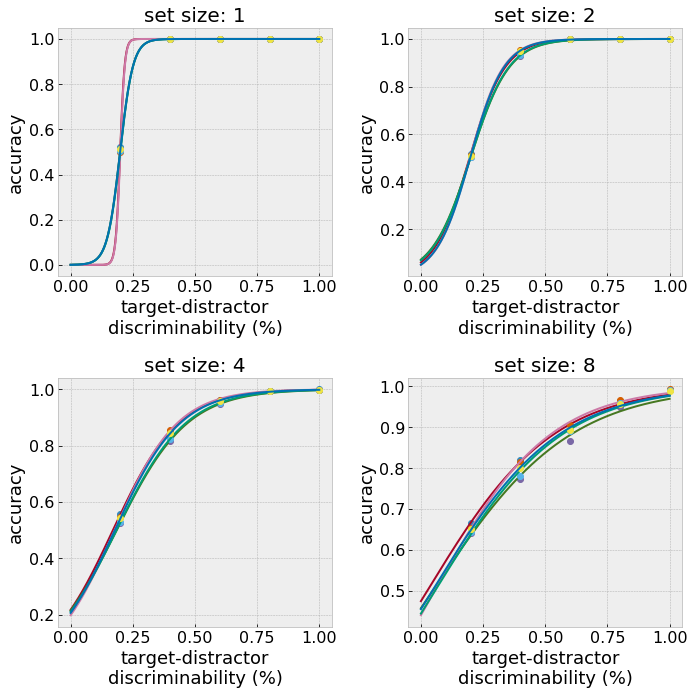

In [45]:
epoch_for_plot = 800
subject_for_plot = 1
d_range = np.linspace(0,1,1000)

fig, ax = plt.subplots(2, 2)
fig.set_size_inches(10,10)
ax = ax.ravel()
for set_size_ind, set_size in enumerate(set_sizes):
    for subject_ind in range(num_subjects):
        p2 = subjects_by_epochs[epoch_for_plot][subject_ind][set_size]
        ax[set_size_ind].plot(discrim_pct, p2, marker='o', linestyle='None')
        params = fits_by_subject_by_epoch[epoch_for_plot][subject_ind][set_size].params
        ax[set_size_ind].plot(d_range, pf(d_range, params[0], params[1]))
        ax[set_size_ind].set_title(f"set size: {set_size}")
        ax[set_size_ind].set_xlabel('target-distractor\ndiscriminability (%)')
        ax[set_size_ind].set_ylabel('accuracy')

fig.tight_layout()
plt.savefig('../static/psychometric_function_fits.png')

## Use the fit parameters to find the desired difference threshold, i.e. what target-distractor discriminability gives us a difference threshold of X?
Here the threshold was 75%, following Palmer et al. 2000 and references therein (https://www.sciencedirect.com/science/article/pii/S0042698999002448)

In [6]:
TH = 0.75  # we want to look for set size effects at a constant difference threshold

diff_ths = {}  # difference thresholds
for epochs in epoch_list:
    subjects = {}
    for subject_ind in range(num_subjects):
        diff_th_by_set_size = []
        for set_size_ind, set_size in enumerate(set_sizes):
            params = fits_by_subject_by_epoch[epochs][subject_ind][set_size].params
            y = pf(d_range, params[0], params[1])
            th_ind = np.argmin(np.abs(y - TH))  # where (on x-axis) did subject have 75% accuracy for this set size?
            diff_th_by_set_size.append(d_range[th_ind])
        subjects[subject_ind] = diff_th_by_set_size
    diff_ths[epochs] = subjects

diff_ths_log10 = {}  # difference thresholds
for epochs in epoch_list:
    subjects = {}
    for subject_ind in range(num_subjects):
        diff_th_log_by_set_size = []
        for set_size_ind, set_size in enumerate(set_sizes):
            diff_th_log_by_set_size.append(np.log10(diff_ths[epochs][subject_ind][set_size_ind]))
        subjects[subject_ind] = diff_th_log_by_set_size
    diff_ths_log10[epochs] = subjects

/home/bart/anaconda3/envs/searchnets/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


In [7]:
## Log transform, then find mean difference threshold across 'subjects' (training replicates) so we can do linear regression on set size v. difference threshold

In [8]:
log10_set_size = np.log10(set_sizes)
from scipy import stats

mn_diff_ths_epochs = {}
linregress_epochs = {}
for epochs in epoch_list:
    diff_ths_log10_this_epoch = []
    for subject_ind in range(num_subjects):
        diff_ths_log10_this_epoch.append(diff_ths_log10[epochs][subject_ind])
    mn_diff_ths_epochs[epochs] = np.asarray(diff_ths_log10_this_epoch).mean(axis=0)
    linregress_epochs[epochs] = stats.linregress(log10_set_size, mn_diff_ths_epochs[epochs])

/home/bart/anaconda3/envs/searchnets/lib/python3.6/site-packages/numpy/lib/function_base.py:2320: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


In [27]:
epochs

800

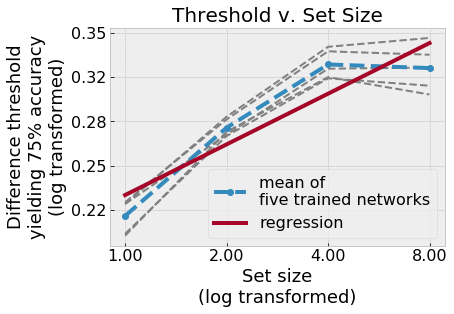

In [43]:
epochs_for_plot = 800

xx = np.log10(np.linspace(1,8,100))
b = linregress_epochs[epochs_for_plot].intercept
m = linregress_epochs[epochs_for_plot].slope
yy = b + (m * xx)

fig, ax = plt.subplots()
subjects_for_plot = diff_ths[epochs_for_plot]
for subject_ind in range(num_subjects):
    ax.plot(np.log10(set_sizes), np.log10(subjects_for_plot[subject_ind]), color='grey', linestyle='--')
ax.plot(np.log10(set_sizes), mn_diff_ths_epochs[epochs_for_plot], linewidth=4, linestyle='--', marker='o', label='mean of\nfive trained networks')
ax.plot(xx, yy, linewidth=4, label='regression')
ax.set_xticks(np.log10(set_sizes))
ax.set_xticklabels([f'{lbl:.2f}' for lbl in 10 ** ax.get_xticks()])
ax.set_yticklabels([f'{lbl:.2f}' for lbl in 10 ** ax.get_yticks()])
ax.set_ylabel('Difference threshold\nyielding 75% accuracy\n(log transformed)')
ax.set_xlabel('Set size\n(log transformed)')
ax.legend(loc='lower right');
ax.set_title('Threshold v. Set Size');
plt.savefig('../static/threshold_v_setsize.png')